<a href="https://colab.research.google.com/github/leticiaram/Modelacion-Epidemiologica/blob/main/4_5_Hamiltonian_Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Ejemplo basado en https://hedibert.org/wp-content/uploads/2021/02/hmc-example.html



# Definimos las funciones.
## Distribución objetivo

 `post` es la función objetivo es una función real con soporte en  $\mathbb{R}
^2$, de la cual queremos muestrear:
$$
\pi(\boldsymbol{\theta})=\kappa\exp\left(−\frac{θ_1^2θ_2^2+θ_1^2+θ_2^2−8θ_1−8θ_2}{2}\right),
$$
donde  $\boldsymbol{\theta}=(\theta_1,\theta_2)$, $k\in\mathbb{R}^+$.
`

In [22]:
import numpy as np

def post(theta):
    """
    Calcula la distribución posterior (sin normalizar)
    Returns:
        float: log-posterior no normalizado
    """
    theta = np.asarray(theta) # Convertir a numpy array
    return np.exp(-0.5 * (np.prod(theta)**2 + np.sum(theta**2) - 8 * np.sum(theta)))





## Graficamos la distribución objetivo

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Crear la malla de puntos
ngrid = 500
th1 = np.linspace(-1, 6.5, ngrid)
th2 = np.linspace(-1, 7, ngrid)

# Crear matriz para almacenar los valores de la función
f = np.zeros((ngrid, ngrid))

# Calcular los valores de la función post() en cada punto de la malla
for i in range(ngrid):
    for j in range(ngrid):
        f[i, j] = post([th1[i], th2[j]])

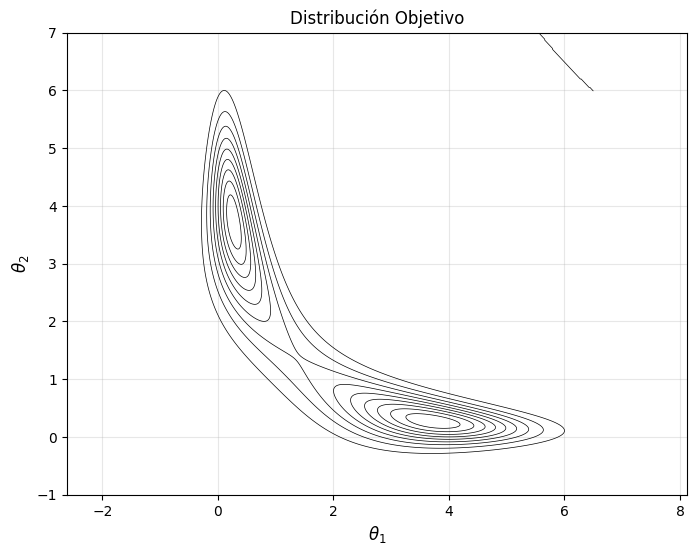

In [24]:
# Crear el gráfico de contorno
plt.figure(figsize=(8, 6))
contour_plot = plt.contour(th1, th2, f.T, levels=10, colors='black',linewidths=0.5)  # Transp f para que coincida con th1, th2
plt.xlabel(r'$\theta_1$', fontsize=12)
plt.ylabel(r'$\theta_2$', fontsize=12)
plt.title('Distribución Objetivo')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

## Establecemos el HMCMC

### Calculamos el logarítmo de la distribución objetivo.

Consideramos
$$
\log \pi(\boldsymbol{\theta})=\log \kappa-0.5 \theta_1^2 \theta_2^2+0.5 \theta_1^2+0.5 \theta_2^2-4 \theta_1-4 \theta_2
$$
con gradiente
$$
\nabla_\theta \log \pi(\theta)=\binom{\frac{\partial \log \pi(\theta)}{\partial \theta_1}}{\frac{\partial \log \pi(\theta)}{\partial \theta_2}}=\binom{-\theta_1 \theta_2^2+\theta_1-4}{-\theta_2 \theta_1^2+\theta_2-4}
$$

### Definimos la función gradiente

In [3]:
def gradient(theta):
    """
    Calcula el gradiente de la función de log-posterior
    Returns:
        numpy array: gradiente [d/dtheta1, d/dtheta2]
    """
    theta1, theta2 = theta
    return np.array([
        -theta1 * theta2**2 + theta1 - 4,
        -theta2 * theta1**2 + theta2 - 4
    ])

### Definimos la función para el Leapfrog

In [ ]:
def leapfrog(theta, p, eps, iM):
    """
    Realiza un paso del algoritmo leapfrog para HMC
    Args:
        theta: posición actual (parámetros)
        p: momento actual
        eps: tamaño del paso
        iM: matriz de masa inversa (precondicionador)
    Returns:
        dict: diccionario con theta y p actualizados
    """
    # Medio paso para el momento
    p = p + (eps / 2) * gradient(theta)
    # Paso completo para la posición
    theta = theta + eps * (iM @ p)
    # Medio paso final para el momento
    p = p + (eps / 2) * gradient(theta)
    return {'theta': theta, 'p': p}



### Corremos el HMCMC

In [29]:
import numpy as np
from scipy.linalg import solve, cholesky

np.random.seed(123456)

M = np.diag([1, 1])
iM = solve(M, np.eye(2))
tcM = cholesky(M).T

# Define burnin and N
burnin = 1000
N = 20000

L = 100
eps = 0.001
theta = np.array([0, 0])
niter = burnin + N
thetas_hmc = np.zeros((niter, 2))

for iter in range(niter):
    p = tcM @ np.random.randn(2)
    theta1 = theta.copy() # Make a copy to avoid modifying theta in place
    p1 = p.copy() # Make a copy to avoid modifying p in place

    for i in range(L):
        run = leapfrog(theta1, p1, eps, iM)
        p1 = run['p']
        theta1 = run['theta']

    # Calculate acceptance probability
    term1 = post(theta1) / post(theta)
    term2_numerator = np.exp(-0.5 * p1.T @ iM @ p1)
    term2_denominator = np.exp(-0.5 * p.T @ iM @ p)
    term2 = term2_numerator / term2_denominator
    accept = min(1, term1 * term2)

    if np.random.uniform(0, 1) < accept:
        theta = theta1
        p = -p1 # Reverse momentum

    thetas_hmc[iter, :] = theta

### Graficamos resultados

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from statsmodels.tsa.stattools import acf # Import acf

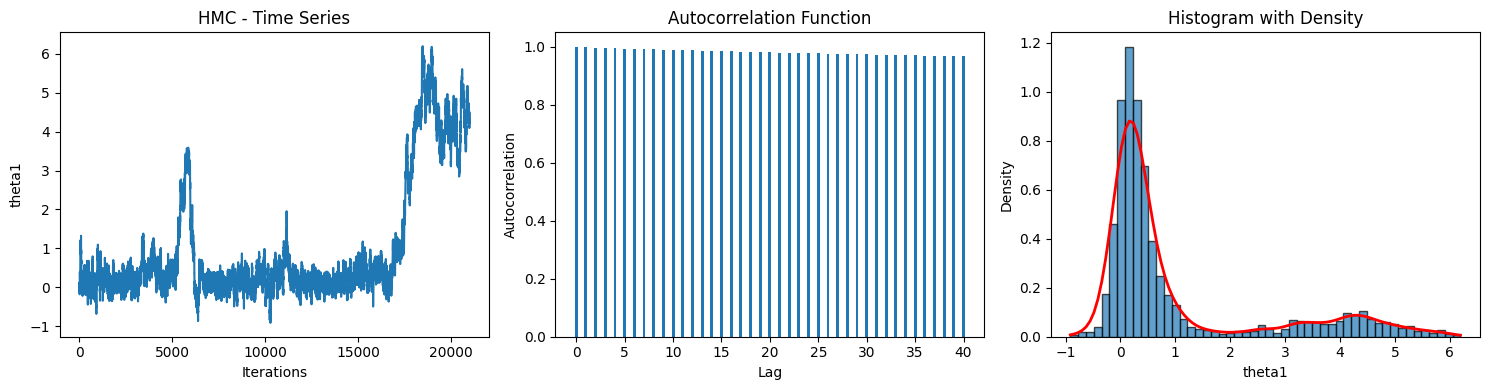

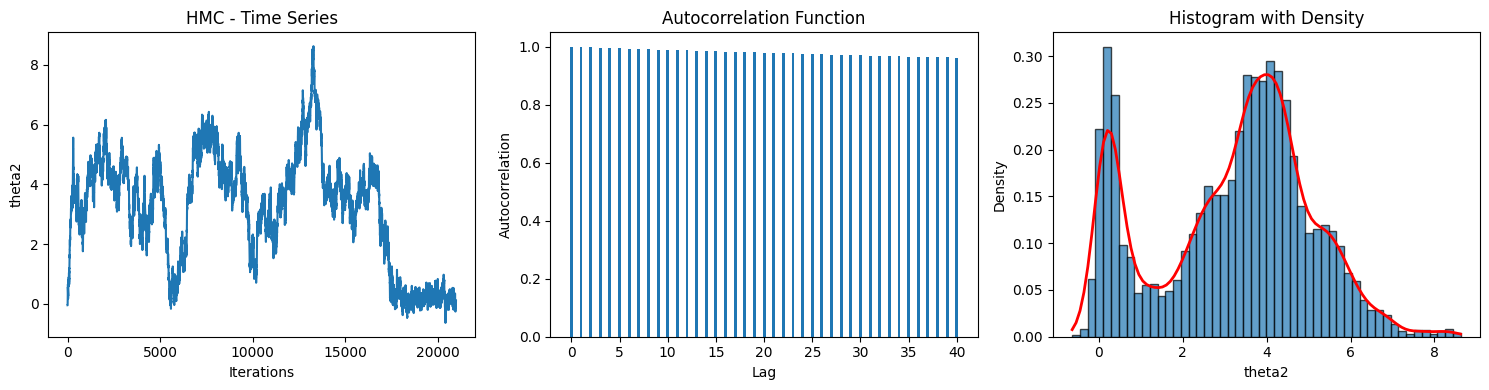

In [31]:
for i in range(2):
    plt.figure(figsize=(15, 4))

    # Time series
    plt.subplot(1, 3, 1)
    plt.plot(thetas_hmc[:, i])
    plt.xlabel("Iterations")
    plt.ylabel(f"theta{i+1}")
    plt.title("HMC - Time Series")

    # ACF
    plt.subplot(1, 3, 2)
    autocorr = acf(thetas_hmc[:, i], nlags=40)
    plt.bar(range(len(autocorr)), autocorr, width=0.3)
    plt.title("Autocorrelation Function")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")

    # Histogram
    plt.subplot(1, 3, 3)
    plt.hist(thetas_hmc[:, i], bins=50, density=True, alpha=0.7, edgecolor='black')
    kde = gaussian_kde(thetas_hmc[:, i])
    x_vals = np.linspace(thetas_hmc[:, i].min(), thetas_hmc[:, i].max(), 100)
    plt.plot(x_vals, kde(x_vals), 'r-', linewidth=2)
    plt.title("Histogram with Density")
    plt.xlabel(f"theta{i+1}")
    plt.ylabel("Density")

    plt.tight_layout()
    plt.show()

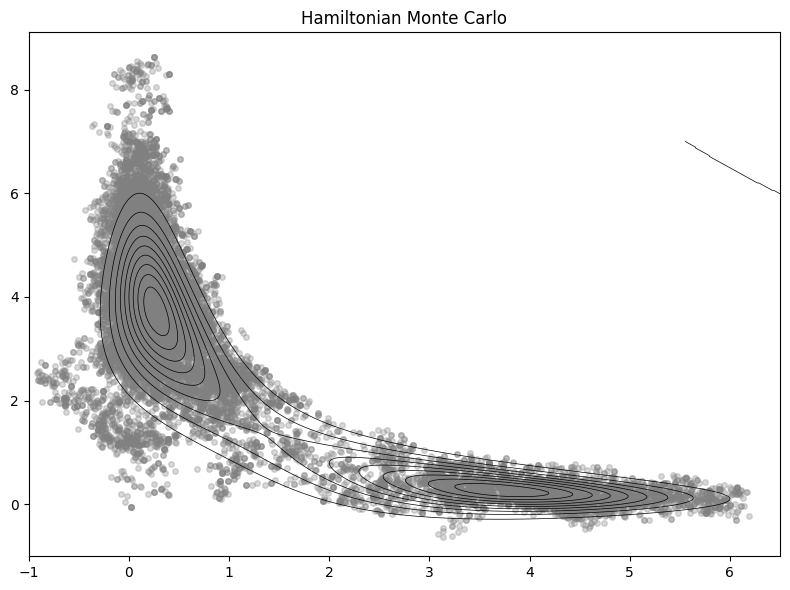

In [32]:
plt.figure(figsize=(8, 6))

# Scatter plot of thetas (equivalent to plot(thetas.hmc, ...))
plt.scatter(thetas_hmc[:, 0], thetas_hmc[:, 1],
           c='grey', alpha=0.3, s=16, marker='o')
contour_plot = plt.contour(th1, th2, f.T, levels=10, colors='black',linewidths=0.5)  # Transp f para que coincida con th1, th2
plt.title("Hamiltonian Monte Carlo")

plt.tight_layout()
plt.show()